# L09 Soluzioni

In [ ]:
from itertools import product, chain

from liblet import (
    Grammar, 
    Production, 
    Derivation, 
    ProductionGraph, 
    cyk2table, 
    prods2table,
    side_by_side
)

from L09 import (
    remove_unproductive_unreachable, 
    eliminate_unit_rules, 
    eliminate_ε_rules, 
    transform_nonsolitary,
    make_binary,
    cyk
)

## La "solita" grammatica (comoda per i test)

In [ ]:
# fig. 4.6, pag. 112

G = Grammar.from_string("""
Number -> Integer | Real
Integer -> Digit | Integer Digit
Real -> Integer Fraction Scale
Fraction -> . Integer
Scale -> e Sign Integer | Empty
Digit -> 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
Sign -> + | -
Empty -> ε
""")

Gp = eliminate_unit_rules(eliminate_ε_rules(G))
G_cnf = make_binary(transform_nonsolitary(remove_unproductive_unreachable(Gp)))
Gp_cnf = make_binary(transform_nonsolitary(Gp))

# Una derivazione rightmost

Come suggerito, l'unica differenza è alla linea 9 della prossima cella, dove per la produzione $A\to BC$ la funzione viene prima richiamata su $C$ e poi su $B$.

In [ ]:
def get_rightmost_prods(G, R, INPUT):
    def prods(X, i, l):
        if l == 1:
            return [G.P.index(Production(X, (INPUT[i - 1],)))]
        for A, (B, C) in filter(Production.such_that(lhs = X, rhs_len = 2), G.P):
            for k in range(1, l):
                if B in R[(i, k)] and C in R[(i + k, l - k)]:
                    return [G.P.index(Production(A, (B, C)))] + prods(C, i + k, l - k) + prods(B, i, k)
    return prods(G.S, 1, len(INPUT))          

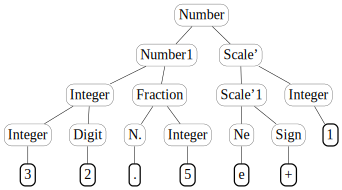

In [ ]:
# per la grammatica di cui sopra, eseguendo quetsa cella
# dovreste ottenere un albero di parsing corretto

INPUT = tuple('32.5e+1') # attenzione: le parole sono sequenze di stringhe!

R = cyk(G_cnf, INPUT)

prods = get_rightmost_prods(G_cnf, R, INPUT)

ProductionGraph(Derivation(G_cnf).rightmost(prods))

# Una derivazione (leftmost) nella grammatica originale

Il primo passo è costruire (per una assegnata tabella `R`  e un assegnato `INPUT` la funzione `derives(ω, i, l)` che restituisce una lista se a forma sentenziale corispondete al primo argomento deriva (in base alle informaizoni nella tabella) la sottoparola dell'input lunga `l` che inizia dall'`i`-esimo simbolo, oppure `None`; la lista è un elenco di lungezze, ciascuna delle quali corrisponde a quanti simboli della sottoparola derivano da ciascun non terminale della forma sentenziale.

In [ ]:
def make_derives(R, INPUT):
    def derives(ω, i, l):
        if not ω or ('ε', ) == ω: 
            return [] if l == 0 else None
        X, *χ = ω
        if X in G.T:
            if i <= len(INPUT) and X == INPUT[i - 1]:
                s = derives(χ, i + 1, l - 1)
                if s is not None: return [1] + s
        else:
            for k in range(0, l + 1):
                if X in R[(i, k)]:
                    s = derives(χ, i + k, l - k)
                    if s is not None: return [k] + s
        return None
    return derives

In [ ]:
Rp = cyk(Gp_cnf, INPUT)
Rε = {A for A in Gp_cnf.N if ('ε', ) in Gp_cnf.alternatives(A)}
for i in range(len(INPUT) + 2): Rp[(i, 0)] = Rε

In [ ]:
# costruiamo derive sulla tabella ed input precedenti

derives = make_derives(Rp, INPUT)

In [ ]:
# una prova di esecuzione 

derives(['Integer', 'Fraction', 'Scale'], 1, len(INPUT))

[2, 2, 3]

I tre non terminali (che sono il lato destro della produzione 
 `Real -> Integer Fraction Scale`) producono l'input (ossia tutti 
 e 7 i suoi simboli a partire dal primo) e più precisamente:

- `Integer` produrrà '35' (una sottoparola lunga 2),
- `Fraction` produrrà '.5' (una sottoparola lunga 2),
- `Scale` produrrà 'e+1', (una sottoparola lunga 3).

Una volta scritta la suddetta funzione basta seguire l'algoritmo descritto a partire da pag. 115.

In [ ]:
def get_original_leftmost_prods(G, derives, N):
    def prods(X, i, l):
        if X in G.T: return []
        for A, α in filter(Production.such_that(lhs = X), G.P):
            d = derives(α, i, l)
            if d is None: continue
            res = [G.P.index(Production(A, α))]
            for B, l in zip(α, d): 
                res.extend(prods(B, i, l))
                i += l
            return res
    return prods(G.S, 1, N)

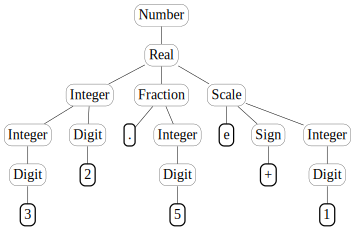

In [ ]:
# un albero di parsing nella grammatica originale

prods = get_original_leftmost_prods(G, derives, len(INPUT))
ProductionGraph(Derivation(G).leftmost(prods))

## E le ϵ-produzioni?

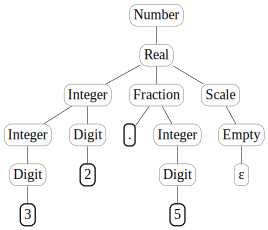

In [ ]:
INPUT = tuple('32.5')

R = cyk(G_cnf, INPUT)
Rp = cyk(Gp_cnf, INPUT)
Rε = {A for A in Gp_cnf.N if ('ε', ) in Gp_cnf.alternatives(A)}
for i in range(len(INPUT) + 2): Rp[(i, 0)] = Rε

prods = get_original_leftmost_prods(G, make_derives(Rp, INPUT), len(INPUT))

ProductionGraph(Derivation(G).leftmost(prods))    

# Tutte le derivazioni leftmost (nella grammatica originale)

Iniziamo da `all_derives(ω, i, l)` che (in analogia a `derives(ω, i, l)`) determini se la forma sentenziale ω deriva una sottoparola dell'input e qualora lo faccia, restituisca una lista di tutte le possibili suddivisioni in cui la sottoparola può essere derivata dai simboli di ω.

In [ ]:
def make_all_derives(R, INPUT): 
    def all_derives(ω, i, l):
        if not ω or ('ε', ) == ω: return (l == 0, [[]])
        res = []
        X, *χ = ω
        if X in G.T:
            if i <= len(INPUT) and X == INPUT[i - 1]:
                d, ss = all_derives(χ, i + 1, l - 1)
                if d: res.extend([1] + s for s in ss)
        else:
            for k in range(0, l + 1):
                if X in R[(i, k)]:
                    d, ss = all_derives(χ, i + k, l - k)
                    if d: res.extend([k] + s for s in ss)
        return (True, res) if res else (False, [[]])
    return all_derives

In [ ]:
# per fare un test consideriamo una grammatica (ambigua) più semplice

G = Grammar.from_string("""
E -> E + E | E * E | e
""")

Gp_cnf = transform_nonsolitary(make_binary(eliminate_unit_rules(eliminate_ε_rules(G))))
prods2table(Gp_cnf)

Una domanda, ma `Gp_cnf` è ancora ambigua?

In [ ]:
# questo input ammette due alberi distinti: 
# uno con il + sopra il * e l'altro viceversa

INPUT = 'e+e*e'

Rp = cyk(Gp_cnf, INPUT)

Rε = {A for A in Gp_cnf.N if ('ε', ) in Gp_cnf.alternatives(A)}
for i in range(1, len(INPUT) + 2): Rp[(i, 0)] = Rε
    
cyk2table(Rp)

In [ ]:
# vediamo se all_derives se ne accorge 

all_derives = make_all_derives(Rp, INPUT) 

all_derives(['E1', 'E'], 1, len(INPUT))

(True, [[2, 3], [4, 1]])

Questa risposta dice che `E1 E` può derivare l'input in due modi: in particolare che `E1` può limitarsi a produrre i due simboli `e+` e quindi `E` può produrre la moltiplicazione, ossia i restanti `e*e`, oppure che `E1` produrrà la somma, ossia i primi quattro simboli `e +e*` e quindi `E` produrrà il terminale `e`.

La costruzione di `get_all_original_leftmost_prods` dovrà determinare (con `all_derive`) le possibili suddivisioni della sottoparola e combinare le derivazioni che otterrà a partire da esse tramite un prodotto cartesiano (come illustrato negli handout).

In [ ]:
def get_all_original_leftmost_prods(G, all_derives, N):
    def all_prods(X, i, l):
        if X in G.T: return [[]]
        res = []
        for A, α in filter(Production.such_that(lhs = X), G.P):
            d, sps = all_derives(α, i, l)
            if not d: continue
            for sp in sps:
                Bprods = []
                bi = i
                for B, li in zip(α, sp): 
                    Bprods.append(all_prods(B, bi, li))
                    bi += li
                for spx in map(list, map(chain.from_iterable, product(*Bprods))):
                    res.append([G.P.index(Production(A, α))] + spx)
        return res
    return all_prods(G.S, 1, N)

In [ ]:
# otteniamo tutte le possibili derivazioni (leftmost)

all_prods = get_all_original_leftmost_prods(G, all_derives, len(INPUT))

In [ ]:
# questi sono i due alberi di parsing per l'input

side_by_side(*[ProductionGraph(Derivation(G).leftmost(prods)) for prods in all_prods])

# Non son tutte rose e fiori

Consideriamo la seguente grammatica 

In [ ]:
G = Grammar.from_string("""
A -> B A | a
B -> b | ε
""")

Gp_cnf = transform_nonsolitary(make_binary(eliminate_unit_rules(eliminate_ε_rules(G))))
prods2table(Gp_cnf)

Non solo è ambigua, ma analizzando $A\to B A$ in `prods` si va incontro ad una ricorsione infinita; questo è una manifestazione del fatto che anche sul più semplice input `a`, la grammatica consente un numero infinito di diverse derivazioni della forma $A\stackrel{k}{\to} B^k A \stackrel{k}{\to} A \to a$.

In [ ]:
INPUT = 'ba'

Rp = cyk(Gp_cnf, INPUT)

Rε = {A for A in Gp_cnf.N if ('ε', ) in Gp_cnf.alternatives(A)}
for i in range(1, len(INPUT) + 2): Rp[(i, 0)] = Rε
    
cyk2table(Rp)

La funzione `derives` che dipende dalla tabella, ma non dalle produzioni, funziona correttamente

In [ ]:
derives = make_derives(Rp, INPUT) 

derives(['B', 'A' ], 1, len(INPUT))

[0, 2]

Ma, come ci aspettiamo, `get_original_leftmost_prods` produrrà una ricorsione infinita.

In [ ]:
try:
    prods = get_original_leftmost_prods(G, derives, len(INPUT))
except RecursionError:
    print('Ricorsione infinita!')

Ricorsione infinita!


Come aggiustereste questo "errore"?